In [ ]:
# !pip install fiftyone
# pip install requests pycocotools pillow

In [2]:
# import fiftyone as fo
# import fiftyone.zoo as foz

import cv2
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import random
import skimage.io as io

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T

import torchvision.transforms as transforms
from torchsummary import summary

import math
import json
from tqdm import tqdm
from google.colab import files

In [3]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download the coco data set

In [ ]:
# Download the COCO validation dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/validation",
#     label_types=["detections"]
#     )

# # Download the COCO training dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/train",
#     label_types=["detections"],
#     # classes=["person"]
#     max_samples=25000,
# )

### Load and visualize Oxford Town

In [5]:
oxford_annotations = pd.read_csv('/content/drive/MyDrive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])
oxford_annotations.head(5)

,personNumber,frameNumber,headNumber,bodyNumber,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


In [ ]:
# oxford_video_path = '/content/drive/MyDrive/Oxford/TownCentreXVID.mp4'

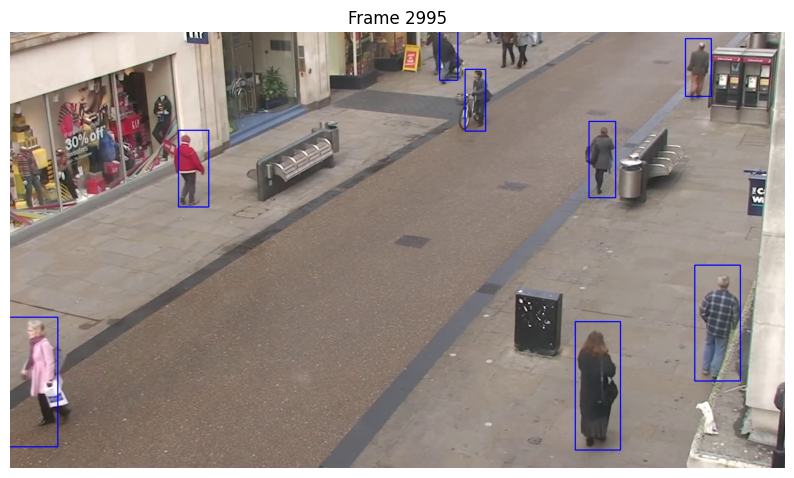

In [6]:
output_dir = '/content/drive/MyDrive/Oxford/Images'

# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes):
    for box in boxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color bounding box
    return image

# Visualize images with bounding boxes
frames = oxford_annotations['frameNumber'].unique()
frames10 = frames[2995:2996]
for frame in frames10:
    frame = int(frame)
    image_path = os.path.join(output_dir, f'{frame}.jpg')
    image = cv2.imread(image_path)

    if image is not None:
        # Extract bounding box coordinates for the current frame
        boxes = oxford_annotations[oxford_annotations['frameNumber'] == frame][['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']].values

        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(image, boxes)

        # Convert BGR image to RGB for matplotlib
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Frame {frame}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for frame {frame} not found.")

### Load and visualize COCO

loading annotations into memory...
Done (t=28.69s)
creating index...
index created!


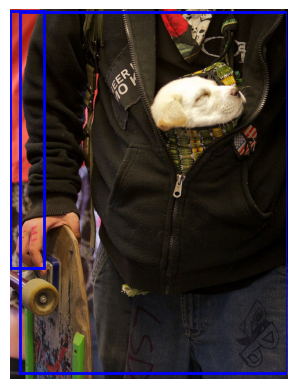

In [7]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"

# Visualize example image
coco = COCO(coco_train_inst_ann_file)
catIds = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catIds)

# Filter images with at least one bounding box annotation
filtered_imgIds = []
for img_id in imgIds:
    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if any(ann['bbox'] for ann in anns):
        filtered_imgIds.append(img_id)

# Initialize random image
random_img_id = random.choice(filtered_imgIds)

# Initialize random image
img = coco.loadImgs(random_img_id)[0]

# Load the image
I = io.imread(img['coco_url'])

fig, ax = plt.subplots()
ax.imshow(I)

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None, catIds=catIds[0])
anns = coco.loadAnns(annIds)

for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(bb)

plt.axis('off')
plt.show()

### Resize, filter and download coco images

In [ ]:
import os
import requests
from pycocotools.coco import COCO
from PIL import Image
from io import BytesIO

def filter_image_ids(img_dir, coco, coco_caps, words):
    # List downloaded images
    downloaded_imgs = set(os.listdir(img_dir))

    # Get image IDs for images containing people
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)

    filtered_img_ids = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        if img_filename in downloaded_imgs:
            ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            if any(ann['bbox'] for ann in anns):
                cap_ids = coco_caps.getAnnIds(imgIds=img_id)
                caps = coco_caps.loadAnns(cap_ids)
                for cap in caps:
                    caption = cap['caption'].lower()
                    if any(word in caption for word in words):
                        filtered_img_ids.append(img_id)
                        break

    print(f"Found {len(filtered_img_ids)} images matching criteria.")
    return filtered_img_ids

def resize_with_padding(image, target_size):
    # Resize while maintaining aspect ratio
    image.thumbnail((target_size, target_size), Image.LANCZOS)
    # Create a new image with the target size and paste the resized image
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
    return new_image

def download_and_resize_images(img_ids, coco, target_dir, target_size):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_url = img_info['coco_url']
        img_filename = img_info['file_name']
        img_path = os.path.join(target_dir, img_filename)

        if not os.path.exists(img_path):
            response = requests.get(img_url)
            image = Image.open(BytesIO(response.content))

            # Resize image
            resized_image = resize_with_padding(image, target_size)
            resized_image.save(img_path)

            print(f"Downloaded and resized {img_filename}")
        else:
            print(f"{img_filename} already exists.")


In [8]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# Directory paths (in Colab working directory)
train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'
filtered_train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/imgs_filtered'
filtered_val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/imgs_filtered'

# Words to filter in captions
words = ['street', 'road', 'city', 'surveillance', 'people']

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

# Filter image IDs
# train_img_ids = filter_image_ids(train_img_dir, coco_train, coco_train_caps, words)
# val_img_ids = filter_image_ids(val_img_dir, coco_val, coco_val_caps, words)

# Download and resize filtered images
target_size = 128  # Set the target size for resizing
# download_and_resize_images(train_img_ids, coco_train, filtered_train_img_dir, target_size)
# download_and_resize_images(val_img_ids, coco_val, filtered_val_img_dir, target_size)

loading annotations into memory...
Done (t=24.47s)
creating index...
index created!
loading annotations into memory...
Done (t=1.77s)
creating index...
index created!
loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!


### Resize and download oxford images

In [ ]:
# Resize and download oxford data

def resize_ox_images(image_dir, target_dir, target_size):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for img_filename in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_filename)
        target_path = os.path.join(target_dir, img_filename)

        if os.path.exists(target_path):
            print(f"{img_filename} already exists, skipping.")
            continue
        # Open image
        try:
          image = Image.open(img_path)

          # Resize image
          resized_image = resize_with_padding(image, target_size)

          # Save image
          resized_image.save(target_path)
          print(f"Resized and saved {img_filename}")
        except Exception as e:
          print(f"Error processing {img_filename}: {e}")

source_dir = '/content/drive/MyDrive/Oxford/Images'  # Source directory
target_dir = '/content/drive/MyDrive/Oxford/imgs_filtered'  # Target directory in Google Drive or local Colab
target_size = 128  # Desired size for resizing

# Resize images
# resize_ox_images(source_dir, target_dir, target_size)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Resized and saved 325.jpg
Resized and saved 3250.jpg
Resized and saved 3251.jpg
Resized and saved 3252.jpg
Resized and saved 3253.jpg
Resized and saved 3254.jpg
Resized and saved 3255.jpg
Resized and saved 3256.jpg
Resized and saved 3257.jpg
Resized and saved 3258.jpg
Resized and saved 3259.jpg
Resized and saved 326.jpg
Resized and saved 3260.jpg
Resized and saved 3261.jpg
Resized and saved 3262.jpg
Resized and saved 3263.jpg
Resized and saved 3264.jpg
Resized and saved 3265.jpg
Resized and saved 3266.jpg
Resized and saved 3267.jpg
Resized and saved 3268.jpg
Resized and saved 3269.jpg
Resized and saved 327.jpg
Resized and saved 3270.jpg
Resized and saved 3271.jpg
Resized and saved 3272.jpg
Resized and saved 3273.jpg
Resized and saved 3274.jpg
Resized and saved 3275.jpg
Resized and saved 3276.jpg
Resized and saved 3277.jpg
Resized and saved 3278.jpg
Resized and saved 3279.jpg
Resized and saved 328.jpg
Resized and saved 3

### Convert coco data to yolo format

In [ ]:
# def convert_coco_to_yolo(coco_json_path, images_dir, output_dir):
#     with open(coco_json_path) as f:
#         coco_data = json.load(f)

#     # Create the output directory if it doesn't exist
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     # Extract images and annotations from COCO data
#     images = {img['id']: img for img in coco_data['images']}
#     annotations = coco_data['annotations']

#     # Set up progress bar
#     progress_bar = tqdm(total=len(annotations), desc="Converting annotations")

#     for ann in annotations:
#         img_id = ann['image_id']
#         img_info = images[img_id]

#         img_filename = img_info['file_name']
#         img_path = os.path.join(images_dir, img_filename)

#         # Check if the image file exists
#         if not os.path.exists(img_path):
#             progress_bar.update(1)
#             continue

#         img_width = img_info['width']
#         img_height = img_info['height']

#         # COCO bbox format: [x, y, width, height]
#         x, y, width, height = ann['bbox']

#         # Convert to YOLO format: [class_id, center_x, center_y, width, height]
#         center_x = x + width / 2
#         center_y = y + height / 2

#         # Normalize the values
#         center_x /= img_width
#         center_y /= img_height
#         width /= img_width
#         height /= img_height

#         class_id = 0  # All annotations are for the person category

#         yolo_ann = f"{class_id} {center_x} {center_y} {width} {height}\n"

#         # Write the YOLO annotation to a file
#         output_file = os.path.join(output_dir, f"{os.path.splitext(img_filename)[0]}.txt")
#         with open(output_file, 'a') as f_out:
#             f_out.write(yolo_ann)

#         # Update progress bar
#         progress_bar.update(1)

#     # Close the progress bar
#     progress_bar.close()

# # Example usage:

# output_dir_train = '/content/yolo_annotations/coco/train'
# convert_coco_to_yolo(coco_train_inst_ann_file, train_img_dir, output_dir_train)


# output_dir_val = '/content/yolo_annotations/coco/val'
# convert_coco_to_yolo(coco_val_inst_ann_file, val_img_dir, output_dir_val)

Converting annotations: 100%|██████████| 36781/36781 [00:36<00:00, 1005.39it/s]


In [9]:

def adjust_bbox(bbox, orig_size, target_size):
    orig_width, orig_height = orig_size
    target_width, target_height = target_size

    # Calculate scale and padding
    scale = min(target_width / orig_width, target_height / orig_height)
    new_width = int(orig_width * scale)
    new_height = int(orig_height * scale)

    pad_x = (target_width - new_width) // 2
    pad_y = (target_height - new_height) // 2

    # Adjust bbox
    x, y, width, height = bbox
    x = x * scale + pad_x
    y = y * scale + pad_y
    width *= scale
    height *= scale

    return [x, y, width, height]

def convert_coco_to_yolo(coco_json_path, images_dir, output_dir, target_size):
    with open(coco_json_path) as f:
        coco_data = json.load(f)

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract images and annotations from COCO data
    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']

    # Set up progress bar
    progress_bar = tqdm(total=len(annotations), desc="Converting annotations")

    for ann in annotations:
        img_id = ann['image_id']
        img_info = images[img_id]

        img_filename = img_info['file_name']
        img_path = os.path.join(images_dir, img_filename)

        # Check if the image file exists
        if not os.path.exists(img_path):
            progress_bar.update(1)
            continue

        img_width = img_info['width']
        img_height = img_info['height']

        # Adjust bbox for the resized image
        bbox = ann['bbox']
        adjusted_bbox = adjust_bbox(bbox, (img_width, img_height), (target_size, target_size))

        # Convert to YOLO format: [class_id, center_x, center_y, width, height]
        x, y, width, height = adjusted_bbox
        center_x = x + width / 2
        center_y = y + height / 2

        # Normalize the values
        center_x /= target_size
        center_y /= target_size
        width /= target_size
        height /= target_size

        class_id = 0  # All annotations are for the person category

        yolo_ann = f"{class_id} {center_x} {center_y} {width} {height}\n"

        # Write the YOLO annotation to a file
        output_file = os.path.join(output_dir, f"{os.path.splitext(img_filename)[0]}.txt")
        with open(output_file, 'a') as f_out:
            f_out.write(yolo_ann)

        # Update progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()


output_dir_train = '/content/yolo_anns/coco/train'
target_size = 128

convert_coco_to_yolo(coco_train_inst_ann_file, train_img_dir, output_dir_train, target_size)

output_dir_val = '/content/yolo_anns/coco/val'

convert_coco_to_yolo(coco_val_inst_ann_file, val_img_dir, output_dir_val, target_size)

Converting annotations: 100%|██████████| 36781/36781 [00:34<00:00, 1053.21it/s]


In [10]:
# Download the files

%cd "/content/yolo_anns/coco/"
!zip -r val.zip val/
!zip -r train.zip train/

files.download('train.zip')
files.download('val.zip')

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  adding: train/000000111940.txt (deflated 63%)
  adding: train/000000115006.txt (deflated 68%)
  adding: train/000000052470.txt (deflated 53%)
  adding: train/000000006107.txt (deflated 61%)
  adding: train/000000013278.txt (deflated 52%)
  adding: train/000000035717.txt (deflated 49%)
  adding: train/000000105689.txt (deflated 47%)
  adding: train/000000091454.txt (deflated 46%)
  adding: train/000000018994.txt (deflated 55%)
  adding: train/000000110762.txt (deflated 37%)
  adding: train/000000106850.txt (deflated 48%)
  adding: train/000000007789.txt (deflated 41%)
  adding: train/000000121384.txt (deflated 34%)
  adding: train/000000024776.txt (deflated 45%)
  adding: train/000000077298.txt (deflated 68%)
  adding: train/000000080953.txt (deflated 64%)
  adding: train/000000054401.txt (deflated 30%)
  adding: train/000000026908.txt (deflated 48%)
  adding: train/000000022281.txt (deflated 63%)
  adding: train/00000

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Convert oxford data to yolo format

In [ ]:
# def adjust_bbox_ox(x_min, y_min, x_max, y_max, orig_size, target_size):
#     orig_width, orig_height = orig_size
#     target_width, target_height = target_size, target_size

#     scale = min(target_width / orig_width, target_height / orig_height)
#     new_width = int(orig_width * scale)
#     new_height = int(orig_height * scale)

#     pad_x = (target_width - new_width) // 2
#     pad_y = (target_height - new_height) // 2

#     x_min = x_min * scale + pad_x
#     y_min = y_min * scale + pad_y
#     x_max = x_max * scale + pad_x
#     y_max = y_max * scale + pad_y

#     return [x_min, y_min, x_max, y_max]

# def convert_ox_annotations(annotations_file, images_dir, output_dir, target_size):

#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)

#     progress_bar = tqdm(total=len(annotations_file), desc="Converting annotations")

#     yolo_lines = []
#     for _, annotation in annotations_file.iterrows():
#         frame_number = annotation['frameNumber']
#         img_filename = f'{frame_number}.jpg'
#         img_path = os.path.join(images_dir, img_filename)

#         if not os.path.exists(img_path):
#             continue

#         img_width, img_height = get_image_dimensions(img_path)

#         adjusted_bbox = adjust_bbox_ox(annotation['bodyLeft'], annotation['bodyBottom'], annotation['bodyRight'], annotation['bodyTop'], (img_width, img_height), (target_size, target_size))
#         x_min, y_min, x_max, y_max = adjusted_bbox
#         center_x = (x_min + x_max) / 2 / target_size
#         center_y = (y_min + y_max) / 2 / target_size
#         width = (x_max - x_min) / target_size
#         height = (y_max - y_min) / target_size

#         class_id = 0
#         yolo_line = f"{class_id} {center_x} {center_y} {width} {height}\n"
#         yolo_lines.append(yolo_line)

#         output_file = os.path.join(output_dir, f'{frame_number}.txt')
#         with open(output_file, 'w') as f_out:
#             f_out.writelines(yolo_lines)

#         progress_bar.update(1)

# def get_image_dimensions(image_path):
#     img = Image.open(image_path)
#     return img.size


# images_dir = '/content/drive/MyDrive/Oxford/imgs_filtered'
# output_dir = '/content/yolo_ann/oxford'
# target_size = 128

# convert_ox_annotations(oxford_annotations, images_dir, output_dir, target_size)

Converting annotations:   0%|          | 0/47747 [00:13<?, ?it/s]


In [33]:
def adjust_bbox_ox(x_min, y_min, x_max, y_max, orig_size, target_size):
    orig_width, orig_height = orig_size
    target_width, target_height = target_size, target_size

    scale = min(target_width / orig_width, target_height / orig_height)
    new_width = int(orig_width * scale)
    new_height = int(orig_height * scale)

    pad_x = (target_width - new_width) // 2
    pad_y = (target_height - new_height) // 2

    x_min = x_min * scale + pad_x
    y_min = y_min * scale + pad_y
    x_max = x_max * scale + pad_x
    y_max = y_max * scale + pad_y

    return [x_min, y_min, x_max, y_max]

def convert_ox_annotations(annotations_df, images_dir, output_dir, target_size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # progress_bar = tqdm(total=len(annotations_df), desc="Converting annotations")

    for _, annotation in annotations_df.iterrows():
        frame_number = int(annotation['frameNumber'])

        # skip damaged image
        if frame_number == 1134:
          # progress_bar.update(1)
          continue

        img_filename = f'{frame_number}.jpg'
        img_path = os.path.join(images_dir, img_filename)

        if not os.path.exists(img_path):
            # progress_bar.update(1)
            continue

        img_width, img_height = get_image_dimensions(img_path)

        adjusted_bbox = adjust_bbox_ox(annotation['bodyLeft'], annotation['bodyTop'], annotation['bodyRight'], annotation['bodyBottom'], (img_width, img_height), target_size)
        x_min, y_min, x_max, y_max = adjusted_bbox
        center_x = (x_min + x_max) / 2 / target_size
        center_y = (y_min + y_max) / 2 / target_size
        width = (x_max - x_min) / target_size
        height = (y_max - y_min) / target_size

        class_id = 0
        yolo_line = f"{class_id} {center_x} {center_y} {width} {height}\n"

        output_file = os.path.join(output_dir, f'{frame_number}.txt')
        with open(output_file, 'a') as f_out:
            f_out.write(yolo_line)

        # progress_bar.update(1)

    # progress_bar.close()

def get_image_dimensions(image_path):
    img = Image.open(image_path)
    return img.size


images_dir = '/content/drive/MyDrive/Oxford/imgs_filtered'
output_dir = '/content/yolo_anns/oxford'
target_size = 128

convert_ox_annotations(oxford_annotations, images_dir, output_dir, target_size)

In [34]:
%cd "/content/yolo_anns"
!zip -r oxford.zip oxford/

files.download('oxford.zip')

/content/yolo_anns
  adding: oxford/ (stored 0%)
  adding: oxford/1449.txt (deflated 62%)
  adding: oxford/2630.txt (deflated 59%)
  adding: oxford/2418.txt (deflated 60%)
  adding: oxford/863.txt (deflated 59%)
  adding: oxford/1348.txt (deflated 61%)
  adding: oxford/1796.txt (deflated 60%)
  adding: oxford/612.txt (deflated 61%)
  adding: oxford/1421.txt (deflated 61%)
  adding: oxford/1694.txt (deflated 61%)
  adding: oxford/259.txt (deflated 58%)
  adding: oxford/2300.txt (deflated 61%)
  adding: oxford/708.txt (deflated 61%)
  adding: oxford/2011.txt (deflated 59%)
  adding: oxford/519.txt (deflated 61%)
  adding: oxford/1649.txt (deflated 61%)
  adding: oxford/32.txt (deflated 57%)
  adding: oxford/2892.txt (deflated 53%)
  adding: oxford/1369.txt (deflated 61%)
  adding: oxford/548.txt (deflated 62%)
  adding: oxford/2443.txt (deflated 59%)
  adding: oxford/2964.txt (deflated 56%)
  adding: oxford/2483.txt (deflated 59%)
  adding: oxford/749.txt (deflated 60%)
  adding: oxford/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>